In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install Sastrawi
!pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip cc.id.300.bin.gz

In [5]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Activation,Dropout,LSTM,Flatten
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D, Bidirectional,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

import pandas as pd
import re

import numpy as np
import fasttext as ft
import keras

In [62]:
data = pd.read_csv("/content/drive/MyDrive/Penggalian Data/archive/data_prep.csv", encoding='ISO-8859-1')
data.head()

Unnamed: 0  ...                                      Cleaned Tweet
0           0  ...  saat semua cowok usaha lacak perhati gue kamu ...
1           1  ...  rt pengguna pengguna siapa yang telat memberi ...
2           2  ...  41 kadang aku berpikir kenapa aku tetap percay...
3           3  ...  pengguna pengguna aku itu akunnku tau mata sip...
4           4  ...  pengguna pengguna kaum cebong kafir sudah liha...

[5 rows x 15 columns]

In [ ]:
data.info()

In [64]:
data_tweet = data[['Tweet', 'HS', 'Abusive','Cleaned Tweet']].copy()
data_tweet.head()

Tweet  ...                                      Cleaned Tweet
0  - disaat semua cowok berusaha melacak perhatia...  ...  saat semua cowok usaha lacak perhati gue kamu ...
1  RT USER: USER siapa yang telat ngasih tau elu?...  ...  rt pengguna pengguna siapa yang telat memberi ...
2  41. Kadang aku berfikir, kenapa aku tetap perc...  ...  41 kadang aku berpikir kenapa aku tetap percay...
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...  ...  pengguna pengguna aku itu akunnku tau mata sip...
4  USER USER Kaum cebong kapir udah keliatan dong...  ...  pengguna pengguna kaum cebong kafir sudah liha...

[5 rows x 4 columns]

In [65]:
kamus = pd.read_csv("/content/drive/MyDrive/Tugas Besar Semester 6/archive/new_kamusalay.csv", encoding='ISO-8859-1', header=None)
kamus.rename(columns={0:"alay", 1:"normal"}, inplace=True)
kamus.head()

alay                    normal
0  anakjakartaasikasik  anak jakarta asyik asyik
1         pakcikdahtua         pak cik sudah tua
2       pakcikmudalagi         pak cik muda lagi
3          t3tapjokowi              tetap jokowi
4                   3x                 tiga kali

### Preprocessing Function

In [66]:
alay = list(kamus['alay'])
normal = list(kamus['normal'])

def remove_alay(text):
  text_split = text.split()

  for word in text_split:
    if word in alay:
      word_index = text_split.index(word)
      kamus_index = alay.index(word)

      text_split[word_index] = normal[kamus_index]
      result = ' '.join(text_split)
  else:
    result = ' '.join(text_split)

  return result

In [67]:
def stop_words(text):
  stop_factory = StopWordRemoverFactory().get_stop_words()
  more_stopword = ['user', 'rt', 'url']
  data = stop_factory + more_stopword
  dictionary = ArrayDictionary(data)
  stopword = StopWordRemover(dictionary)

  for i in range(0, 2):
      text = stopword.remove(text)

  return text

In [68]:
def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  text   = stemmer.stem(text)
  return text

In [69]:
def clean_text(text, alay, stop, stem):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)

  if stem == True:
    text = stemming(text)  

  if alay == True:
    text = remove_alay(text)

  if stop == True:
    text = stop_words(text)

  return text

### Preprocessing I

In [70]:
data_tweet['Cleaned Tweet'] = data_tweet['Tweet'].apply(lambda x: clean_text(x, alay=False, stop=True, stem=False))
data_tweet.head()

Tweet  ...                                      Cleaned Tweet
0  - disaat semua cowok berusaha melacak perhatia...  ...   disaat semua cowok berusaha melacak perhatian...
1  RT USER: USER siapa yang telat ngasih tau elu?...  ...  siapa telat ngasih tau eluedan sarap gue berga...
2  41. Kadang aku berfikir, kenapa aku tetap perc...  ...  41 kadang aku berfikir aku tetap percaya tuhan...
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...  ...       aku akunnku tau matamu sipit diliat mana aku
4  USER USER Kaum cebong kapir udah keliatan dong...  ...  kaum cebong kapir udah keliatan dongoknya awal...

[5 rows x 4 columns]

In [ ]:
data_tweet.head(10)

### Preprocessing Part II

In [72]:
target = data_tweet[['HS','Abusive']]
target.head()

HS  Abusive
0   1        1
1   0        1
2   0        0
3   0        0
4   1        1

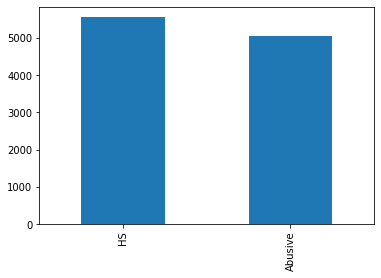

In [73]:
target.sum(axis=0).plot.bar()

In [74]:
X = data_tweet['Cleaned Tweet'].to_list()
y = target.values

In [75]:
y

array([[1, 1],
       [0, 1],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [1, 1]])

In [76]:
vocab_size = 5000
token = Tokenizer(num_words = vocab_size)
token.fit_on_texts(X)

encoded_text = token.texts_to_sequences(X)
print(encoded_text[1])

[90, 2372, 1253, 64, 416, 23, 4137, 11, 90, 2373]


In [77]:
len = 100
padded_text = pad_sequences(encoded_text, maxlen=len, padding='post')
print(padded_text[1]) 

# https://www.youtube.com/watch?v=kKDYtZfriI8&t=461s ni link kalau mo liat yens

[  90 2372 1253   64  416   23 4137   11   90 2373    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


### Fasttext embedding

In [35]:
embed_model2 = ft.load_model("cc.id.300.bin")

In [57]:
t = Tokenizer()
embedding_matrix = np.zeros((vocab_size, 64))
for word,i in t.word_index.items():
    embedding_vector = embed_model2[word]
    embedding_matrix[i] = embedding_vector

### Modelling Tanpa Fasttext


In [82]:
X_train, X_test, y_train, y_test = train_test_split(padded_text, y, test_size=0.20, random_state=42)

In [83]:
model = Sequential()

model.add(Embedding(vocab_size, 64, input_length=len))
model.add(Conv1D(128,6))
model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
# model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="sigmoid"))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 95, 128)           49280     
_________________________________________________________________
activation_6 (Activation)    (None, 95, 128)           0         
_________________________________________________________________
global_average_pooling1d_6 ( (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)               

In [84]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])


In [85]:
#testing
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
330/330 [==============================] - 11s 32ms/step - loss: 0.5735 - acc: 0.7276 - val_loss: 0.4409 - val_acc: 0.6879
Epoch 2/50
330/330 [==============================] - 10s 31ms/step - loss: 0.3940 - acc: 0.7067 - val_loss: 0.3998 - val_acc: 0.7213
Epoch 3/50
330/330 [==============================] - 10s 31ms/step - loss: 0.3067 - acc: 0.7288 - val_loss: 0.3474 - val_acc: 0.7403
Epoch 4/50
330/330 [==============================] - 10s 31ms/step - loss: 0.2191 - acc: 0.6671 - val_loss: 0.3516 - val_acc: 0.6929
Epoch 5/50
330/330 [==============================] - 10s 31ms/step - loss: 0.1639 - acc: 0.6516 - val_loss: 0.3863 - val_acc: 0.6682
Epoch 6/50
330/330 [==============================] - 10s 31ms/step - loss: 0.1311 - acc: 0.6477 - val_loss: 0.4640 - val_acc: 0.6355
Epoch 7/50
330/330 [==============================] - 10s 31ms/step - loss: 0.1054 - acc: 0.6365 - val_loss: 0.5122 - val_acc: 0.6420
Epoch 8/50
330/330 [==============================] - 10s 31ms

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [28]:
print("Acc epoch 50")
plot_graphs(history, 'acc')

Acc epoch 50


Acc epoch 50


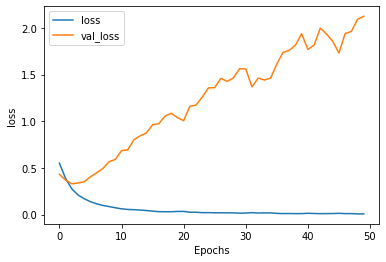

In [30]:
print("Acc epoch 50")
plot_graphs(history, 'loss')

Acc epoch 50 dengan stopword


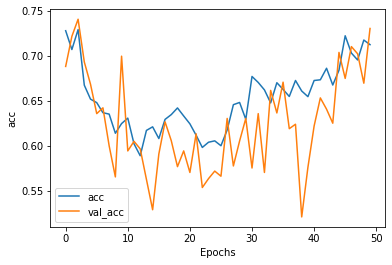

In [86]:
print("Acc epoch 50 dengan stopword")
plot_graphs(history, 'acc')

In [87]:
print("Loss epoch 50 dengan stopword")
plot_graphs(history, 'loss')

Loss epoch 50 dengan stopword


# Modelling dengan Fastext

In [96]:
X_train, X_test, y_train, y_test = train_test_split(padded_text, y, test_size=0.20, random_state=42)

In [97]:
model = Sequential()

model.add(Embedding(vocab_size, 64,weights = [embedding_matrix], input_length=len,trainable = False))
model.add(Conv1D(128,5))
model.add(Activation('relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
# model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="sigmoid"))
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 96, 128)           41088     
_________________________________________________________________
activation_9 (Activation)    (None, 96, 128)           0         
_________________________________________________________________
global_average_pooling1d_9 ( (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)               

In [98]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])


In [99]:
#testing
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
330/330 [==============================] - 7s 19ms/step - loss: 0.6851 - acc: 0.8664 - val_loss: 0.6784 - val_acc: 0.8705
Epoch 2/50
330/330 [==============================] - 6s 19ms/step - loss: 0.6766 - acc: 0.8664 - val_loss: 0.6735 - val_acc: 0.8705
Epoch 3/50
330/330 [==============================] - 6s 18ms/step - loss: 0.6743 - acc: 0.8664 - val_loss: 0.6723 - val_acc: 0.8705
Epoch 4/50
330/330 [==============================] - 6s 19ms/step - loss: 0.6738 - acc: 0.8664 - val_loss: 0.6719 - val_acc: 0.8705
Epoch 5/50
330/330 [==============================] - 6s 19ms/step - loss: 0.6737 - acc: 0.8664 - val_loss: 0.6718 - val_acc: 0.8705
Epoch 6/50
330/330 [==============================] - 6s 18ms/step - loss: 0.6737 - acc: 0.8664 - val_loss: 0.6718 - val_acc: 0.8705
Epoch 7/50
330/330 [==============================] - 6s 19ms/step - loss: 0.6737 - acc: 0.8664 - val_loss: 0.6718 - val_acc: 0.8705
Epoch 8/50
330/330 [==============================] - 6s 19ms/step - 

In [40]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

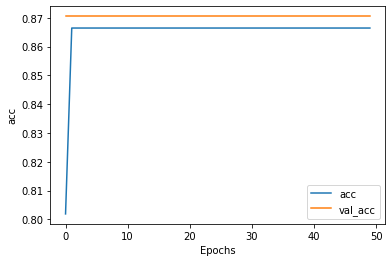

In [41]:
plot_graphs(history, 'acc')

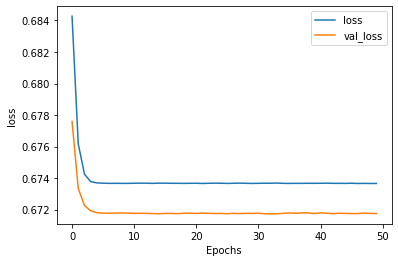

In [42]:
plot_graphs(history, 'loss')